<a href="https://colab.research.google.com/github/cweikucf/cap4630/blob/master/HW_4/ConnerWeik_CAP4630_Homework4_Problem3_Classifier1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conner Weik
# CAP 4630, Spring 2020
# Homework 4, Problem 3
# Classifier 1
If something doesn't work, please try doing run all or let me know. Thanks!

For both classifiers, I will be using InceptionV3 as the conv base, and I will be unfreezing the top 30 layers of the conv base, that is, the layer named batch_normalization_90 and all layers above it.

For this classifier, I will use the following layers, added in the following order:

Flatten()

Dense(256, activation='relu')

Dense(4, activation='relu')

Dense(1, activation='sigmoid')


For both classifiers, I will be using 20 epochs for the pre-fine-tuning training and 20 epochs for the fine-tuning.

# Imports and stuff

In [0]:
import os
import zipfile
from keras.applications import InceptionV3
from keras import layers
from keras import models
from keras import optimizers


## Feature extraction

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

We will use here the convolutional base of the VGG16 model to extract the features. We will feed these features to a densely connected classifier with dropout. We will fine-tune some layers.

## Download the data

Download the example data as in the original notebook.



In [0]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-04-22 01:50:36--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.11.176, 2607:f8b0:4007:802::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.11.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   132MB/s    in 0.5s    

2020-04-22 01:50:37 (132 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

## Build network with InceptionV3 convolution base and custom densely connected layers

### Load the convolutional base

In [0]:
from keras.applications import InceptionV3

conv_base = InceptionV3(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

### Freeze the convolutional base

In [0]:
conv_base.trainable = False

### Concatenate the convolutional base and densely connected layers

In [0]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_2 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               4718848   
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 1028      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 5         
Total params: 26,522,665
Trainable params: 4,719,881
Non-trainable params: 21,802,784
_________________________________________________________________


## Train the model end to end with frozen convolutional base

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/20
100/100 [==============================] - 23s 227ms/step - loss: 0.5889 - acc: 0.6735 - val_loss: 0.1408 - val_acc: 0.9200
Epoch 2/20
100/100 [==============================] - 18s 177ms/step - loss: 0.5049 - acc: 0.7515 - val_loss: 0.2094 - val_acc: 0.8900
Epoch 3/20
100/100 [==============================] - 18s 178ms/step - loss: 0.4668 - acc: 0.7675 - val_loss: 0.1173 - val_acc: 0.9380
Epoch 4/20
100/100 [==============================] - 18s 176ms/step - loss: 0.4438 - acc: 0.7880 - val_loss: 0.3683 - val_acc: 0.9380
Epoch 5/20
100/100 [==============================] - 18s 178ms/step - loss: 0.4272 - acc: 0.7935 - val_loss: 1.4210 - val_acc: 0.8710
Epoch 6/20
100/100 [==============================] - 18s 179ms/step - loss: 0.4238 - acc: 0.8030 - val_loss: 0.0386 - val_acc: 0.9400
Epoch 7/20
100/100 [==============================] - 18s 178ms/step - loss: 0.4131 - acc: 0.8060 - val_lo

## Display curves of loss and accuracy during training

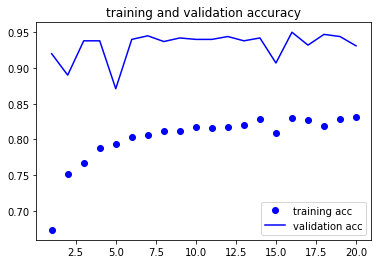

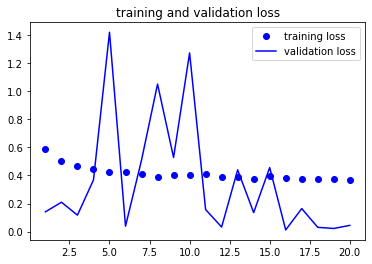

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

## Fine-tuning

## Show the layers of the network

In [0]:
for layer in conv_base.layers:
  print(layer.name)

input_2
conv2d_95
batch_normalization_95
activation_95
conv2d_96
batch_normalization_96
activation_96
conv2d_97
batch_normalization_97
activation_97
max_pooling2d_5
conv2d_98
batch_normalization_98
activation_98
conv2d_99
batch_normalization_99
activation_99
max_pooling2d_6
conv2d_103
batch_normalization_103
activation_103
conv2d_101
conv2d_104
batch_normalization_101
batch_normalization_104
activation_101
activation_104
average_pooling2d_10
conv2d_100
conv2d_102
conv2d_105
conv2d_106
batch_normalization_100
batch_normalization_102
batch_normalization_105
batch_normalization_106
activation_100
activation_102
activation_105
activation_106
mixed0
conv2d_110
batch_normalization_110
activation_110
conv2d_108
conv2d_111
batch_normalization_108
batch_normalization_111
activation_108
activation_111
average_pooling2d_11
conv2d_107
conv2d_109
conv2d_112
conv2d_113
batch_normalization_107
batch_normalization_109
batch_normalization_112
batch_normalization_113
activation_107
activation_109
activa

I will be unfreezing the top 30 layers of the conv base, that is, the layer named batch_normalization_90 and all layers above it.

In [0]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'batch_normalization_90':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [0]:
# compile model

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/20
100/100 [==============================] - 24s 240ms/step - loss: 0.3511 - acc: 0.8425 - val_loss: 0.1899 - val_acc: 0.9330
Epoch 2/20
100/100 [==============================] - 18s 184ms/step - loss: 0.3517 - acc: 0.8405 - val_loss: 0.2305 - val_acc: 0.9150
Epoch 3/20
100/100 [==============================] - 18s 184ms/step - loss: 0.3534 - acc: 0.8395 - val_loss: 0.1866 - val_acc: 0.8950
Epoch 4/20
100/100 [==============================] - 18s 181ms/step - loss: 0.3441 - acc: 0.8505 - val_loss: 0.2610 - val_acc: 0.8910
Epoch 5/20
100/100 [==============================] - 18s 182ms/step - loss: 0.3396 - acc: 0.8405 - val_loss: 0.1098 - val_acc: 0.8820
Epoch 6/20
100/100 [==============================] - 18s 182ms/step - loss: 0.3306 - acc: 0.8440 - val_loss: 0.2226 - val_acc: 0.8890
Epoch 7/20
100/100 [==============================] - 18s 184ms/step - loss: 0.3654 - acc: 0.8350 - val_loss: 0.4251 - val_acc: 0.8860
Epoch 8/20
100/100 [==============================] - 1

## Display learning curves during fine-tuning

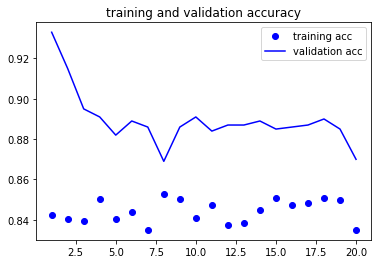

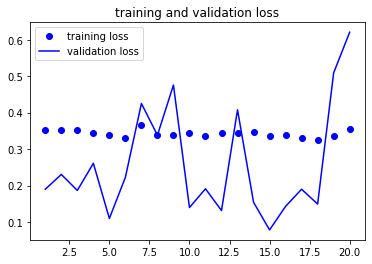

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

## Print out validation loss and accuracy

In [0]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)

In [0]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: 0.29284992814064026
Validation accuracy: 0.8700000047683716
